# Gradient based optimisation using PT-MPO

In this tutorial, ah here i'm not arsed writing this right now


In [18]:
import numpy as np
import oqupy
import matplotlib.pyplot as plt

## Setting up the system and the optimisation problem

The first thing we do is set up the problem, generate a process tensor, save it, write a cost function

In [19]:
dt = 0.05
dkmax = 60
esprel = 10**(-7)
alpha = 0.126

omega_cutoff = 3.04


In [20]:

temperature = 5 * 0.1309 # 1K = 0.1309/ps in natural units
max_time = 5

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2.0, correlations)

tempo_params = oqupy.TempoParameters(dt=dt, dkmax=dkmax, epsrel=esprel)



In [ ]:
generate_process_tensor = False

In [21]:
if generate_process_tensor:
    process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                            start_time=0,
                                            end_time=max_time,
                                            parameters=tempo_params,
                                            # progress_type='silent'
                                            )

    process_tensor.export('optimisation_pt.processTensor',overwrite=True)

else:
    process_tensor = oqupy.import_process_tensor(
                'optimisation_pt.processTensor','simple')

### Defining the objective function

There are two parts that are necessary: 

- A cost function, which in the case of this tutorial will be the Ullmann Fidelity / Infidelity between a target *pure* state $|\sigma\rangle$ and a final density matrix which will be computed by PT-MPO $\rho_f$
$$
\mathcal{F} = \langle\sigma|\rho_f|\sigma\rangle
$$

- A gradient function which computes $\frac{\partial\mathcal{F}}{\partial c_i}$

First we state the cost function and then show how to get the gradient using the adjoint method and the `oqupy.get_gradient_and_dynamics` function

Before this we need to specify a system hamiltonian.

#### Defining the system hamiltonian

For simplicity we will restrict ourselves to a two level system where we apply fields conjugate to two of the spin operators

$$
H_{\text{sys}} = h_x S_x + h_z S_z
$$

The hamiltonian is discretised into timesteps of duration `dt` and we choose the discrete value $h_\bullet$ to be constant across each timestep. We make no other form of parameterisation.

In [22]:
from scipy.interpolate import interp1d
from oqupy.process_tensor import BaseProcessTensor
from oqupy.helpers import get_full_timesteps


In [23]:

def get_hamiltonian(hx:np.ndarray,hz:np.ndarray,pt:BaseProcessTensor):

    # interp doesn't extrapolate beyond the last point so any time after t-dt will be out of bounds
    # need to duplicate the final point so we create the very last 'pixel'
    expval_times = get_full_timesteps(pt,0)
    assert hx.size == expval_times.size, 'hx must be same length as number of timesteps'
    assert hz.size == expval_times.size, 'hz must be same length as number of timesteps'
    # expval_times plus one timestep
    expval_times_p1 = np.concatenate((expval_times,np.array([pt.dt * len(pt)])))
    # duplicate last element so any time between t_f-dt and t_f falls within this 'pixel'
    # otherwise scipy interp1d doesn't like extrapolating so calls it out of bounds
    hx_p1 = np.concatenate((hx,np.array([hx[-1]])))
    hz_p1 = np.concatenate((hz,np.array([hz[-1]])))

    hx_interp = interp1d(expval_times_p1,hx_p1,kind='zero')
    hz_interp = interp1d(expval_times_p1,hz_p1,kind='zero')

    def hamiltonian_t(t):
        _hx = hx_interp(t)
        _hz = hz_interp(t)

        hx_sx = 0.5 * oqupy.operators.sigma('x') * _hx
        hz_sz = 0.5 * oqupy.operators.sigma('z') * _hz
        hamiltonian = hz_sz + hx_sx
        return hamiltonian

    return hamiltonian_t

In [24]:
# times = get_full_timesteps(process_tensor,0)
# # pi pulse conjugate to s_z
# h_z = np.ones(times.size) *np.pi / max_time
# h_x = np.zeros(times.size)
# hamiltonian_t = get_hamiltonian(hx=h_x,hz=h_z,pt=process_tensor)
# hamiltonian_t(4.0)

Now the cost function:

In [25]:

def cost_function(
                control_parameters,
                pt,
                initial_state = oqupy.operators.spin_dm("z-"),
                target_state = oqupy.operators.spin_dm("z+")):


    # take some arbitrary hamiltonian (will specify this later)
    hamiltonian_t = get_hamiltonian(control_parameters,pt)#  this obv broken


    system = oqupy.TimeDependentSystem(hamiltonian_t)
    final_state = oqupy.compute_dynamics(
                    system,
                    initial_state,
                    start_time=0,
                    process_tensor=pt)
    final_state = pt.compute(system,initial_state=initial_state)
    fidelity = 1 - np.matmul(final_state,target_state).trace() # infidelity

    return fidelity.real


Now the gradient:

We start off by finding the finite difference routine that will get the derivative of the system propagators with respect to the control parameters defined above. The finite difference routine is

Now we show the gradient function:

We note that because the gradient and cost funciton are defined seperatedly, which is somewhat ineficient because we cannot take into account that when calculating the gradient the fidelity is also calculated. This should probabkly be fixed and i'd imagine is also not an issue with the Krotov algorithm.

We restrict ourselves to an optimisation where each time-step is an optimisation parameter, and we take a finite difference chain rule as described in the other tutorial

In [26]:
from scipy.linalg import expm
from typing import Optional

In [27]:

def time_dependent_finite_difference(
                    process_tensor,
                    system,
                    times,  # again same point as above, why does it need to be repeated.
                    operator, #the operator to differentiate wrt
                    h=10**(-6),
                    timesteps_used: Optional[int] = None): # finite difference timestep
    '''this is a very specific case where the number of derivatives == the number of half timestep propagators
    TODO: figure out if that's actually correct'''

    ham=system.hamiltonian

    def dpropagator(system,
        t, # expectation value times
        dt,
        op,
        h):
        '''
        deriv of propagator wrt the pre node and the post node
        '''

        post_liouvillian_plus_h=-1j * oqupy.operators.commutator(ham(t+dt*3.0/4.0)+h*op)
        post_liouvillian_minus_h=-1j * oqupy.operators.commutator(ham(t+dt*3.0/4.0)-h*op)

        post_propagator_plus_h=expm(post_liouvillian_plus_h*dt/2.0).T
        post_propagator_minus_h=expm(post_liouvillian_minus_h*dt/2.0).T

        postderiv=(post_propagator_plus_h-post_propagator_minus_h)/(2.0*h)

        pre_liouvillian_plus_h=-1j * oqupy.operators.commutator(ham(t+dt*1.0/4.0)+h*op)
        pre_liouvillian_minus_h=-1j * oqupy.operators.commutator(ham(t+dt*1.0/4.0)-h*op)

        pre_propagator_plus_h=expm(pre_liouvillian_plus_h*dt/2.0).T
        pre_propagator_minus_h=expm(pre_liouvillian_minus_h*dt/2.0).T
        prederiv=(pre_propagator_plus_h-pre_propagator_minus_h)/(2.0*h)
        return prederiv,postderiv


    derivs = []

    for step in range(times.size):
        prederiv,postderiv=dpropagator(system,times[step],process_tensor.dt,operator,h)
        derivs.append(prederiv)
        derivs.append(postderiv)

    return derivs


lets see what the gradient of a constant $\pi$ pulse looks like

In [28]:
from oqupy.helpers import get_half_timesteps
times = get_full_timesteps(process_tensor,0)
expval_times = oqupy.helpers.get_full_timesteps(process_tensor,0)

# pi pulse conjugate to s_z
h_x = np.ones(times.size) *np.pi / max_time
h_z = np.zeros(times.size)
hamiltonian_t = get_hamiltonian(hx=h_x,hz=h_z,pt=process_tensor)
system = oqupy.TimeDependentSystem(hamiltonian_t)

dprop_dpram_times = get_half_timesteps(process_tensor,0)


In [29]:


dprop_dpram_derivs_x = time_dependent_finite_difference(
                process_tensor=process_tensor,
                system=system,
                times=times,
                operator=0.5*oqupy.operators.sigma('x'))


total_derivs_x = oqupy.gradient(
                system=system,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                dprop_dparam_list=dprop_dpram_derivs_x,
                dprop_times_list=dprop_dpram_times,
                process_tensor=process_tensor,)


--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:17
Elapsed time: 18.0s


In [30]:


dprop_dpram_derivs_z = time_dependent_finite_difference(
                process_tensor=process_tensor,
                system=system,
                times=times,operator=oqupy.operators.sigma('z'))


total_derivs_z = oqupy.gradient(
                system=system,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                dprop_dparam_list=dprop_dpram_derivs_z,
                dprop_times_list=dprop_dpram_times,
                process_tensor=process_tensor,)


--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:14
Elapsed time: 14.1s


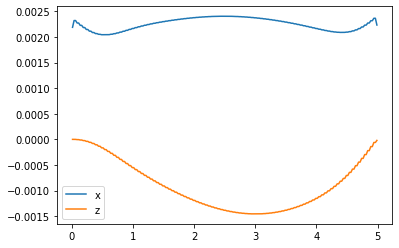

In [31]:
plt.figure()
plt.plot(dprop_dpram_times,total_derivs_x.real,label='x')
plt.plot(dprop_dpram_times,total_derivs_z.real,label='z')

plt.legend()
plt.show()


In [16]:
from tqdm.contrib import tenumerate

def compute_finite_difference_brute(
                        pt_instance: oqupy.SimpleProcessTensor,
                        hamiltonian,
                        initial_state,
                        target_state,
                        times,
                        operator,
                        h = 10**-6):
    ''' doesn't use the adjoint method, just computes the frichét derivatives by
    brute force'''

    assert operator.shape[0] == pt_instance.hilbert_space_dimension,\
         'input operator is a different H.S. dimension to the system'
    dt = pt_instance.dt
    def hamiltonian_perturbed(operator,h,dt,time):
        def _hamiltonian_perturbed(t):
            if time-dt/2 < t < time+dt/2:
                return hamiltonian(t) + h * operator
            return hamiltonian(t)
        return _hamiltonian_perturbed

    derivative_array = np.zeros(times.size,dtype=np.complex128)
    for i,time in tenumerate(times):
        ham_plus_h = hamiltonian_perturbed(operator,h,dt,time)
        ham_minus_h = hamiltonian_perturbed(operator,-h,dt,time)

        system_plus_h = oqupy.TimeDependentSystem(ham_plus_h)
        system_minus_h = oqupy.TimeDependentSystem(ham_minus_h)

        dynamics_forward = oqupy.compute_dynamics(
                    system_plus_h,
                    initial_state,
                    start_time=0,
                    process_tensor=pt_instance,
                    record_all=False,
                    progress_type='silent')
        dynamics_backward = oqupy.compute_dynamics(
                    system_minus_h,
                    initial_state,
                    start_time=0,
                    process_tensor=pt_instance,
                    record_all=False,
                    progress_type='silent')
        final_state_forward = dynamics_forward.states[0,:,:]
        final_state_backward = dynamics_backward.states[0,:,:]

        fidelity_forward = 1 - np.matmul(target_state,final_state_forward).trace()
        fidelity_backward = 1 - np.matmul(target_state,final_state_backward).trace()

        derivative = (fidelity_forward - fidelity_backward) / (2 * h)

        derivative_array[i] = derivative
        np.save('deriv_array',derivative_array)

    return derivative_array



In [ ]:
generate_finite_differnce_z = False
generate_finite_differnce_x = False

In [ ]:
if generate_finite_differnce_z:
    fd_z = compute_finite_difference_brute(
                process_tensor,
                hamiltonian_t,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=expval_times,
                operator=oqupy.operators.sigma('z')
                )

    np.save('deriv_array_z',fd_z)


: 

In [ ]:
if generate_finite_differnce_x:
    fd_x = compute_finite_difference_brute(
                process_tensor,
                hamiltonian_t,
                initial_state=oqupy.operators.spin_dm('z-'),
                target_state=oqupy.operators.spin_dm('z+'),
                times=expval_times,
                operator=oqupy.operators.sigma('x')
                )
    np.save('deriv_array_x',fd_x)


: 

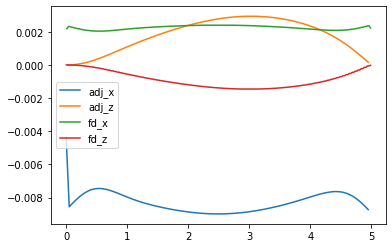

In [34]:

deriv_array_x = np.load('deriv_array_x.npy')
deriv_array_z = np.load('deriv_array_z.npy')
plt.plot(expval_times,deriv_array_x.real,label='adj_x')
plt.plot(expval_times,deriv_array_z.real,label='adj_z')

plt.plot(dprop_dpram_times,total_derivs_x.real,label='fd_x')
plt.plot(dprop_dpram_times,total_derivs_z.real,label='fd_z')

plt.legend()